In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.models import Sequential , Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

from IPython.display import Image


Using TensorFlow backend.


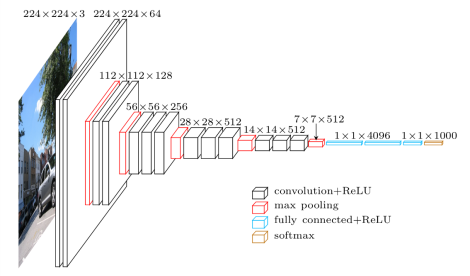

In [2]:
Image('./vgg16.png')

In [4]:
train_path = './data/train'
valid_path = './data/valid'
test_path  = './data/test'


In [5]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [6]:
def load_image(paths):
    images = [plt.imread(path) for path in paths]
    
    return np.asarray(images)

In [7]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
data_gen = ImageDataGenerator(
    rescale = 1.0 / 255.0
)

train_gen = data_gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    shuffle = True,
    color_mode = 'rgb',
    class_mode='categorical'
)

valid_gen = data_gen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    color_mode = 'rgb',
    class_mode='categorical'
)

test_gen = data_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode = 'rgb',
    class_mode='categorical'
)

Found 450 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


['pumpkin' 'tomato' 'watermelon']
3


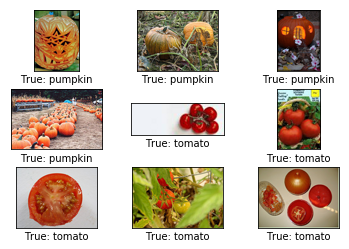

In [104]:
cls_train = train_gen.classes
cls_valid = valid_gen.classes

images_train_path = path_join(train_path,train_gen.filenames)
images_valid_path = path_join(valid_path,valid_gen.filenames)


class_names_dict = train_gen.class_indices

class_names = np.array(class_names_dict.keys())
class_names = class_names[np.argsort(class_names_dict.values())]

print class_names

num_classes = len(class_names)

print num_classes

images_train = load_image(images_train_path[146:155])
plot_images(images_train,cls_train[146:155])


In [10]:
model = VGG16(include_top=True, weights='imagenet' )

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
conv_model = Model(inputs=model.input, outputs = model.get_layer('fc2').output)

In [13]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
new_model = Sequential()

#new_model.add(model.get_layer('block5_pool'))
new_model.add(conv_model)


#new_model.add(Dropout(0.5))

new_model.add(Dense(num_classes,activation='softmax'))


In [15]:
new_model = Model(inputs=new_model.input, outputs=new_model.output)

In [16]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1_input (InputLayer)   (None, 224, 224, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 4096)              134260544 
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12291     
Total params: 134,272,835
Trainable params: 134,272,835
Non-trainable params: 0
_________________________________________________________________


In [17]:
for layer in conv_model.layers:
    
    print'{} {}'.format(layer.name, layer.trainable)

input_1 False
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
flatten True
fc1 True
fc2 True


In [18]:
for layer in conv_model.layers:
    layer.trainable = False

In [19]:
for layer in conv_model.layers:
    
    print'{} {}'.format(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten False
fc1 False
fc2 False


In [20]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1_input (InputLayer)   (None, 224, 224, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 4096)              134260544 
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12291     
Total params: 134,272,835
Trainable params: 12,291
Non-trainable params: 134,260,544
_________________________________________________________________


In [21]:
opt = Adam(lr=1e-4)
loss = 'categorical_crossentropy'

In [22]:
new_model.compile(optimizer = opt, loss = loss)

In [26]:
history = new_model.fit_generator(generator = train_gen,
                                 epochs = 10,
                                  steps_per_epoch=50,
                                 validation_data=valid_gen,
                                  validation_steps=5)

Epoch 1/10
50/50 [==============================] - 926s 19s/step - loss: 1.0846 - val_loss: 1.0712
Epoch 2/10
50/50 [==============================] - 1092s 22s/step - loss: 0.9902 - val_loss: 0.9509
Epoch 3/10
50/50 [==============================] - 930s 19s/step - loss: 0.9149 - val_loss: 0.8834
Epoch 4/10
50/50 [==============================] - 921s 18s/step - loss: 0.8895 - val_loss: 0.8858
Epoch 5/10
50/50 [==============================] - 923s 18s/step - loss: 0.8817 - val_loss: 0.8156
Epoch 6/10
50/50 [==============================] - 909s 18s/step - loss: 0.8318 - val_loss: 0.8352
Epoch 7/10
50/50 [==============================] - 921s 18s/step - loss: 0.8097 - val_loss: 0.7998
Epoch 8/10
50/50 [==============================] - 921s 18s/step - loss: 0.7802 - val_loss: 0.8072
Epoch 9/10
50/50 [==============================] - 904s 18s/step - loss: 0.7655 - val_loss: 0.7299
Epoch 10/10
50/50 [==============================] - 922s 18s/step - loss: 0.7406 - val_loss: 0.782

In [38]:
def plot_training_history(history):
    # Get the classification loss
    # for the training-set.
    loss = history.history['loss']

    # Get it for the validation-set 

    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(loss, linestyle='-', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_loss, linestyle='--', color='r', label='Validation Loss')

    # Plot title and legend.
    plt.title('Training and Validation Loss')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

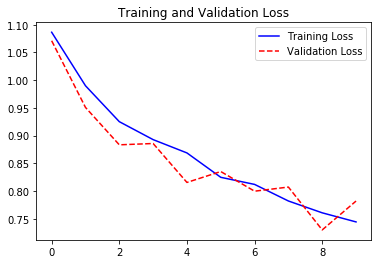

In [50]:
plot_training_history(history)

In [68]:
print new_model.evaluate_generator(test_gen,steps=len(test_gen))

0.849201192855835


In [108]:
images_test_path = path_join(test_path,test_gen.filenames)
#print images_test_path
#cls_test = test_gen.classes

#print cls_test

In [112]:
#test_gen.reset()
cls_test = test_gen.classes

# Predict the classes for all images in the test-set.
y_pred = new_model.predict_generator(test_gen,
                                     steps=len(test_gen))
cls_pred = np.argmax(y_pred,axis=1)

In [115]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(images_test_path)[incorrect]

    # Load the first 9 images.
    images = load_image(image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

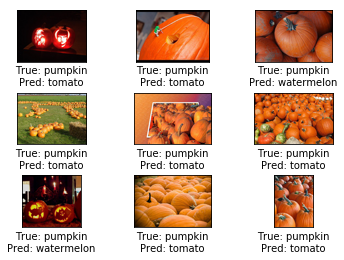

In [116]:
plot_example_errors(cls_pred)